In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception

2025-10-05 19:18:34.212438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759691914.410522      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759691914.467119      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
if os.path.exists("food-101"):
    shutil.rmtree("food-101")
if os.path.exists("food-101-subset"):
    shutil.rmtree("food-101-subset")
if not os.path.exists("food-101.tar.gz"):
    !wget -c http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
!tar -xzf food-101.tar.gz food-101/images

data_dir   = "food-101/images"
subset_dir = "food-101-subset"
os.makedirs(subset_dir, exist_ok=True)

# =======================
# 3) Select 20 classes + copy images
# =======================
selected_classes = [
    'guacamole', 'hot_and_sour_soup', 'ravioli', 'caprese_salad', 'chocolate_mousse',
    'strawberry_shortcake', 'oysters', 'sashimi', 'poutine', 'deviled_eggs',
    'huevos_rancheros', 'prime_rib', 'panna_cotta', 'tacos', 'beef_carpaccio',
    'donuts', 'waffles', 'bread_pudding', 'beignets', 'mussels'
]

for cls in selected_classes:
    src_folder = os.path.join(data_dir, cls)
    dst_folder = os.path.join(subset_dir, cls)
    os.makedirs(dst_folder, exist_ok=True)
    imgs = os.listdir(src_folder)
    for img in imgs:
        shutil.copy(os.path.join(src_folder, img), os.path.join(dst_folder, img))

print("✅ Copied all images for", len(selected_classes), "classes")

--2025-10-05 19:18:46--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2025-10-05 19:18:46--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  29.9MB/s    in 2m 36s  

2025-10-05 19:21:22 (30.6 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]

✅ Copied all images for 20 classes


In [6]:
# === prepare_data.py ===

import os, shutil, random
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess


# Input/output folders
SRC = 'food-101-subset'   # Folder chứa 20 lớp ảnh
BASE = 'food20_split'     # Folder mới chứa split: train/val/test

# Split ratio
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# Image sizes
IMG_SIZE_CUST = 224   # For custom CNN
IMG_SIZE_TL   = 299   # For Xception
BATCH_SIZE = 32

# --- STEP 1: SPLIT DATA ---
if os.path.exists(BASE):
    shutil.rmtree(BASE)
os.makedirs(BASE, exist_ok=True)

print("📂 Splitting data into train/val/test...")

for cls in sorted(os.listdir(SRC)):
    src_cls = os.path.join(SRC, cls)
    if not os.path.isdir(src_cls):
        continue

    imgs = [os.path.join(src_cls, f) for f in os.listdir(src_cls) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    
    train_val, test = train_test_split(imgs, test_size=TEST_RATIO, random_state=SEED)
    val_size = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)
    train, val = train_test_split(train_val, test_size=val_size, random_state=SEED)

    for split_name, files in [('train', train), ('val', val), ('test', test)]:
        out_dir = os.path.join(BASE, split_name, cls)
        os.makedirs(out_dir, exist_ok=True)
        for p in files:
            shutil.copy(p, out_dir)

print("✅ Done splitting. Data stored in:", BASE)

# --- STEP 2: DATA GENERATORS ---
print("🔄 Creating data generators...")

# Custom CNN generators (rescale only)
train_datagen_cust = ImageDataGenerator(rescale=1./255)
val_datagen_cust = ImageDataGenerator(rescale=1./255)

# Xception generators (with preprocess function)
train_datagen_tl = ImageDataGenerator(preprocessing_function=xception_preprocess)
val_datagen_tl = ImageDataGenerator(preprocessing_function=xception_preprocess)

# --- Custom CNN (IMG_SIZE_CUST = 224) ---
train_gen_cust = train_datagen_cust.flow_from_directory(
    os.path.join(BASE, 'train'),
    target_size=(IMG_SIZE_CUST, IMG_SIZE_CUST),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)
val_gen_cust = val_datagen_cust.flow_from_directory(
    os.path.join(BASE, 'val'),
    target_size=(IMG_SIZE_CUST, IMG_SIZE_CUST),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)
test_gen_cust = val_datagen_cust.flow_from_directory(
    os.path.join(BASE, 'test'),
    target_size=(IMG_SIZE_CUST, IMG_SIZE_CUST),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

# --- Transfer Learning (Xception, IMG_SIZE_TL = 299) ---
train_gen_tl = train_datagen_tl.flow_from_directory(
    os.path.join(BASE, 'train'),
    target_size=(IMG_SIZE_TL, IMG_SIZE_TL),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)
val_gen_tl = val_datagen_tl.flow_from_directory(
    os.path.join(BASE, 'val'),
    target_size=(IMG_SIZE_TL, IMG_SIZE_TL),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)
test_gen_tl = val_datagen_tl.flow_from_directory(
    os.path.join(BASE, 'test'),
    target_size=(IMG_SIZE_TL, IMG_SIZE_TL),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

# --- Class Info ---
CLASS_NAMES = list(train_gen_cust.class_indices.keys())
NUM_CLASSES = len(CLASS_NAMES)
print(f"✅ Found {NUM_CLASSES} classes:", CLASS_NAMES)


📂 Splitting data into train/val/test...
✅ Done splitting. Data stored in: food20_split
🔄 Creating data generators...
Found 16000 images belonging to 20 classes.
Found 2000 images belonging to 20 classes.
Found 2000 images belonging to 20 classes.
Found 16000 images belonging to 20 classes.
Found 2000 images belonging to 20 classes.
Found 2000 images belonging to 20 classes.
✅ Found 20 classes: ['beef_carpaccio', 'beignets', 'bread_pudding', 'caprese_salad', 'chocolate_mousse', 'deviled_eggs', 'donuts', 'guacamole', 'hot_and_sour_soup', 'huevos_rancheros', 'mussels', 'oysters', 'panna_cotta', 'poutine', 'prime_rib', 'ravioli', 'sashimi', 'strawberry_shortcake', 'tacos', 'waffles']


In [10]:
# === model_custom_cnn.py ===
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def build_custom_cnn(input_shape=(224,224,3), num_classes=20):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding='same', kernel_regularizer=regularizers.l2(1e-4))(inp)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, padding='same')(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.30)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512)(x); x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inp, outputs=out)
    return model

# compile example
model_cust = build_custom_cnn((IMG_SIZE_CUST, IMG_SIZE_CUST, 3), NUM_CLASSES)
model_cust.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
model_cust.summary()


I0000 00:00:1759692434.437170      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759692434.437870      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 367,156 (1.40 MB)

 Trainable params: 365,236 (1.39 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [11]:
# === model_transfer_xception.py ===
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models

def build_xception_tl(input_shape=(299,299,3), num_classes=20):
    base = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base.input, outputs=out)
    return model, base

model_tl, base_model = build_xception_tl((IMG_SIZE_TL, IMG_SIZE_TL, 3), NUM_CLASSES)
# Stage 1: freeze base
for layer in base_model.layers:
    layer.trainable = False

model_tl.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                 loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
                 metrics=['accuracy'])
model_tl.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │        512 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 22,050,108 (84.11 MB)

 Trainable params: 1,187,092 (4.53 MB)

 Non-trainable params: 20,863,016 (79.59 MB)

In [12]:
# === train_both.py ===
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)

# Train custom CNN
ckp_cust = ModelCheckpoint('cust_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
history_cust = model_cust.fit(
    train_gen_cust,
    epochs=40,
    validation_data=val_gen_cust,
    callbacks=[es, rlr, ckp_cust],
    verbose=1
)

# Train TL - stage 1
ckp_tl = ModelCheckpoint('tl_stage1_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
history_tl_stage1 = model_tl.fit(
    train_gen_tl,
    epochs=6,
    validation_data=val_gen_tl,
    callbacks=[es, rlr, ckp_tl],
    verbose=1
)

# Stage 2: unfreeze last ~100 layers and fine-tune
unfreeze_from = max(0, len(base_model.layers) - 100)
for i, layer in enumerate(base_model.layers):
    layer.trainable = True if i >= unfreeze_from else False

# (recompile with lower lr)
model_tl.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                 loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
                 metrics=['accuracy'])

ckp_tl2 = ModelCheckpoint('tl_finetuned_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
history_tl_stage2 = model_tl.fit(
    train_gen_tl,
    epochs=30,
    validation_data=val_gen_tl,
    callbacks=[es, rlr, ckp_tl2],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


I0000 00:00:1759692463.732032     155 service.cc:148] XLA service 0x79dfe40a6820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759692463.734204     155 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759692463.734225     155 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759692464.532195     155 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/500 ━━━━━━━━━━━━━━━━━━━━ 3:15:53 24s/step - accuracy: 0.0312 - loss: 3.7697

I0000 00:00:1759692480.032272     155 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.1431 - loss: 3.0088
Epoch 1: val_loss improved from inf to 3.82771, saving model to cust_best.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 97s 146ms/step - accuracy: 0.1431 - loss: 3.0085 - val_accuracy: 0.0630 - val_loss: 3.8277 - learning_rate: 1.0000e-04
Epoch 2/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.2381 - loss: 2.5793
Epoch 2: val_loss improved from 3.82771 to 3.27567, saving model to cust_best.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 76s 151ms/step - accuracy: 0.2381 - loss: 2.5792 - val_accuracy: 0.1820 - val_loss: 3.2757 - learning_rate: 1.0000e-04
Epoch 3/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.2844 - loss: 2.3887
Epoch 3: val_loss did not improve from 3.27567
500/500 ━━━━━━━━━━━━━━━━━━━━ 75s 150ms/step - accuracy: 0.2844 - loss: 2.3887 - val_accuracy: 0.1870 - val_loss: 3.3356 - learning_rate: 1.0000e-04
Epoch 4/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.3128 - loss: 2.2877
Epoch 4: v

2025-10-05 19:44:31.264975: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f32[32,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,147,147]{3,2,1,0}, f32[128,128,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-10-05 19:44:31.538640: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.273769561s
Trying algorithm eng3{k11=0} for conv (f32[32,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,147,147]{3,2,1,0}, f32[128,128,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone

500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.3243 - loss: 2.6833
Epoch 1: val_loss improved from inf to 1.19451, saving model to tl_stage1_best.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 199s 347ms/step - accuracy: 0.3246 - loss: 2.6820 - val_accuracy: 0.7095 - val_loss: 1.1945 - learning_rate: 1.0000e-04
Epoch 2/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.6417 - loss: 1.4702
Epoch 2: val_loss improved from 1.19451 to 1.11672, saving model to tl_stage1_best.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 160s 320ms/step - accuracy: 0.6418 - loss: 1.4702 - val_accuracy: 0.7485 - val_loss: 1.1167 - learning_rate: 1.0000e-04
Epoch 3/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.6937 - loss: 1.2985
Epoch 3: val_loss improved from 1.11672 to 1.06174, saving model to tl_stage1_best.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 160s 319ms/step - accuracy: 0.6937 - loss: 1.2985 - val_accuracy: 0.7585 - val_loss: 1.0617 - learning_rate: 1.0000e-04
Epoch 4/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/

E0000 00:00:1759694491.636576     157 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759694491.791559     157 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759694493.276801     157 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759694493.417912     157 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759694493.922105     157 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.6143 - loss: 1.5462
Epoch 1: val_loss improved from inf to 1.06902, saving model to tl_finetuned_best.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 416s 742ms/step - accuracy: 0.6144 - loss: 1.5459 - val_accuracy: 0.7530 - val_loss: 1.0690 - learning_rate: 1.0000e-05
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.7389 - loss: 1.1553
Epoch 2: val_loss improved from 1.06902 to 0.98418, saving model to tl_finetuned_best.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 365s 729ms/step - accuracy: 0.7390 - loss: 1.1552 - val_accuracy: 0.7840 - val_loss: 0.9842 - learning_rate: 1.0000e-05
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.7827 - loss: 1.0113
Epoch 3: val_loss improved from 0.98418 to 0.93557, saving model to tl_finetuned_best.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 364s 729ms/step - accuracy: 0.7827 - loss: 1.0113 - val_accuracy: 0.8015 - val_loss: 0.9356 - learning_rate: 1.0000e-05
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━

In [16]:
# === eval.py ===
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

def evaluate_model_keras(model, test_gen):
    # Predict all test images
    preds = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_gen.classes  # works because shuffle=False and generator was created similarly
    # Metrics
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    print("Accuracy:", acc)
    print("Precision (macro):", p)
    print("Recall (macro):", r)
    print("F1 (macro):", f1)
    print("\nClassification report:\n")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, zero_division=0))
    # Confusion matrix (optional)
    cm = confusion_matrix(y_true, y_pred)
    return {'accuracy':acc, 'precision':p, 'recall':r, 'f1':f1, 'cm':cm}

# Evaluate custom CNN
model_cust.load_weights('cust_best.h5')
res_cust = evaluate_model_keras(model_cust, test_gen_cust)

# Evaluate TL model
model_tl.load_weights('tl_finetuned_best.h5')
res_tl = evaluate_model_keras(model_tl, test_gen_tl)

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step
Accuracy: 0.235
Precision (macro): 0.3887189999348311
Recall (macro): 0.23499999999999996
F1 (macro): 0.18843592996391217

Classification report:

                      precision    recall  f1-score   support

      beef_carpaccio       0.34      0.58      0.42       100
            beignets       0.12      0.93      0.21       100
       bread_pudding       0.11      0.02      0.03       100
       caprese_salad       1.00      0.04      0.08       100
    chocolate_mousse       0.20      0.15      0.17       100
        deviled_eggs       0.55      0.06      0.11       100
              donuts       0.12      0.09      0.10       100
           guacamole       0.38      0.55      0.45       100
   hot_and_sour_soup       0.50      0.02      0.04       100
    huevos_rancheros       0.50      0.04      0.07       100
             mussels       0.95      0.18      0.30       100
             oysters       0.50      0.03      0.06       100
      

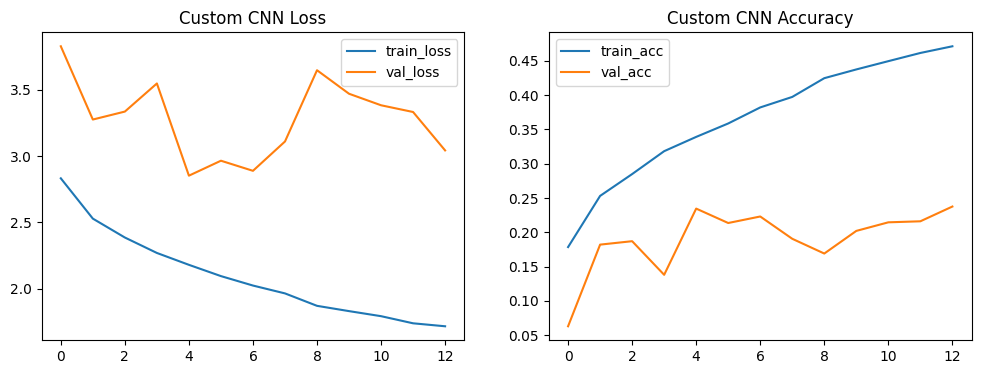

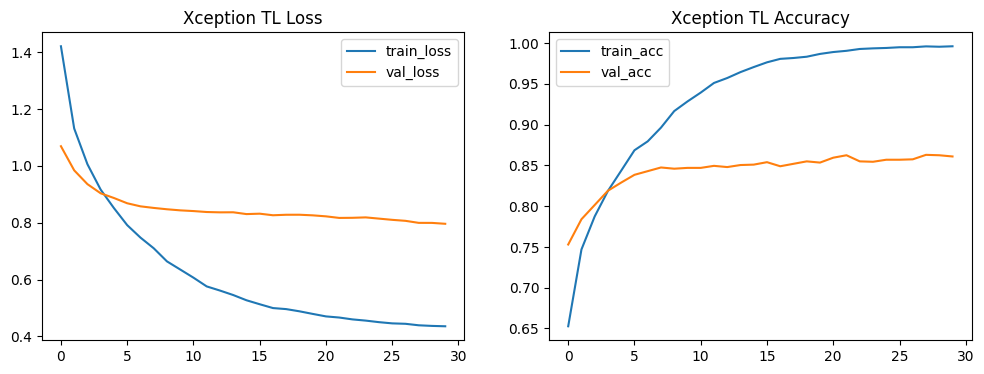

In [17]:
# plot history example
import matplotlib.pyplot as plt

def plot_history(hist, title='Model'):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'], label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.legend(); plt.title(title + ' Loss')
    plt.subplot(1,2,2)
    plt.plot(hist.history.get('accuracy', hist.history.get('acc')), label='train_acc')
    plt.plot(hist.history.get('val_accuracy', hist.history.get('val_acc')), label='val_acc')
    plt.legend(); plt.title(title + ' Accuracy')
    plt.show()

plot_history(history_cust, 'Custom CNN')
plot_history(history_tl_stage2, 'Xception TL')